In [1]:
import os
import sys
import cProfile
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import n2j.inference.infer_utils as iutils
from n2j.inference.inference_manager import InferenceManager
from n2j.config_utils import get_config_modular

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Hierarchical inference

__Author:__ Ji Won Park (@jiwoncpark)

__Created:__ 7/10/2021 

__Last run:__ 8/16/2021

__Goal__: Using the BNN-generated $\kappa$ posteriors, we 
1. infer the population-level distribution in $\kappa$ using importance sampling and 
2. use this information to reweight the individual BNN posteriors so that the interim (training) prior is divided out and the new, inferred test prior reapplied.

__Before running:__
From the repo root, run
```
python infer.py <path to config file>
```

Let's read in the config file, which contains various configs used in training and to be used in inference.

In [2]:
# Paste the path to the config file in the list
cfg = get_config_modular(['../tuning_configs_local_test/nersc_config_T8_N_50.yml'])

We then instantiate the `InferenceManager` and load the training dataset.

In [3]:
infer_obj = InferenceManager(checkpoint_dir=cfg['trainer']['checkpoint_dir'],
                                 **cfg['inference_manager'])
# Load training stats (for normalizing data)
norm_obj = getattr(stats, cfg['data']['train_dist_name'])(**cfg['data']['train_dist_kwargs'])
train_raytracing = [os.path.join(cfg['data']['in_dir'],
                                 f'cosmodc2_{hp}/Y_{hp}') for hp in cfg['data']['train_hp']]
infer_obj.load_dataset(
                       dict(features=cfg['data']['features'],
                            raytracing_out_dirs=train_raytracing,
                            healpixes=cfg['data']['train_hp'],
                            n_data=cfg['data']['n_train'],
                            aperture_size=1.0,
                            subsample_pdf_func=norm_obj.pdf,
                            n_subsample=cfg['data']['n_subsample_train'],
                            stop_mean_std_early=False,
                            in_dir=cfg['data']['in_dir']),
                       sub_features=cfg['data']['sub_features'],
                       sub_target=cfg['data']['sub_target'],
                       sub_target_local=cfg['data']['sub_target_local'],
                       is_train=True,
                       batch_size=cfg['data']['batch_size'],
                       num_workers=cfg['data']['num_workers'],
                       rebin=False,
                       noise_kwargs=cfg['data']['noise_kwargs']
                       )

Mag errors added to ['u', 'g', 'r', 'i', 'z', 'y']
Train dataset size: 100000


Next, let's load the test set, subsampling so that the test sightlines follow a narrow normal as defined by the config file.

In [4]:
norm_obj_test = getattr(stats, cfg['test_data']['dist_name'])(**cfg['test_data']['dist_kwargs'])
test_raytracing = [os.path.join(cfg['data']['in_dir'],
                                f'cosmodc2_{hp}/Y_{hp}') for hp in cfg['test_data']['test_hp']]
infer_obj.load_dataset(dict(features=cfg['data']['features'],
                            raytracing_out_dirs=test_raytracing,
                            healpixes=cfg['test_data']['test_hp'],
                            n_data=cfg['test_data']['n_test'],
                            aperture_size=1.0,
                            subsample_pdf_func=norm_obj_test.pdf,
                            n_subsample=cfg['test_data']['n_subsample_test'],
                            in_dir=cfg['data']['in_dir']),
                       sub_features=cfg['data']['sub_features'],
                       sub_target=cfg['data']['sub_target'],
                       sub_target_local=cfg['data']['sub_target_local'],
                       is_train=False,
                       batch_size=cfg['test_data']['batch_size'],
                       noise_kwargs=cfg['data']['noise_kwargs']
                       )

Test dataset size: 50


We have a broad training prior and a narrow, overdense (high-$\kappa$) test distribution.

(100000,) (50,)


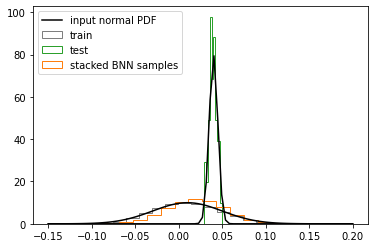

In [5]:
train_k = infer_obj.get_true_kappa(is_train=True).squeeze()
test_k = infer_obj.get_true_kappa(is_train=False).squeeze()
k_bnn = infer_obj.get_bnn_kappa()
grid = np.linspace(-0.15, 0.2, 80)
print(train_k.shape, test_k.shape)
_, bins, _ = plt.hist(train_k, bins=20, density=True, color='tab:gray', label='train', histtype='step')
_ = plt.hist(test_k, bins=10, density=True, color='tab:green', label='test', histtype='step')
_ = plt.hist(k_bnn.reshape(-1), bins=20, density=True, color='tab:orange', label='stacked BNN samples', histtype='step')

plt.plot(grid, norm_obj.pdf(grid), color='k')
plt.plot(grid, norm_obj_test.pdf(grid), color='k', label='input normal PDF')
plt.legend()


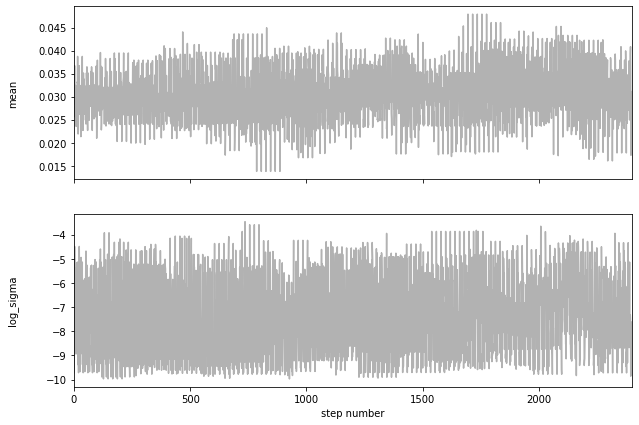

In [6]:
# Path to the stored MCMC chain
chain_path = os.path.join(infer_obj.out_dir, 'omega_chain.h5')
mcmc_samples = iutils.get_mcmc_samples(chain_path, 
                                       chain_kwargs=dict(flat=True, discard=80))
iutils.get_chain_plot(mcmc_samples, None)

(50, 1, 20000)


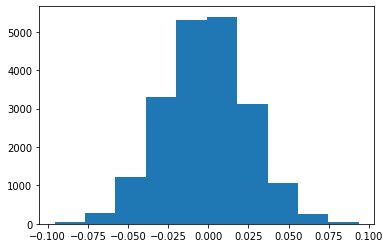

In [7]:
k_bnn = infer_obj.get_bnn_kappa()
print(k_bnn.shape)
_ = plt.hist(k_bnn[0, 0, :])

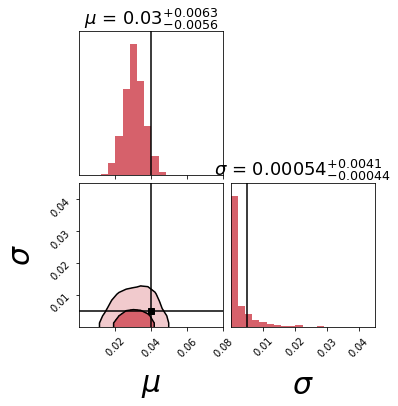

In [8]:
infer_obj.visualize_omega_post(log_idx=1,
                               chain_path=chain_path,
                               corner_kwargs=dict(
                                                 range=[[0, 0.08], [0, 0.045]],
                                                 color='#d6616b',
                                                 smooth=1.0,
                                                 alpha=1.0,
                                                 truths=np.array([0.04, 0.005]),
                                                 label_kwargs={'fontsize': 30},
                                                 labels=[r'$\mu$', r'$\sigma$'],
                                                 fill_contours=True,
                                                 plot_datapoints=False,
                                                 plot_contours=True,
                                                 show_titles=True,
                                                 levels=[0.68, 0.95],
                                                 truth_color='k',
                                                 contour_kwargs=dict(linestyles='solid', colors='k'),
                                      #contourf_kwargs=dict(colors='#843c39'),
                                                 quiet=True,
                                                 #quantiles=[0.5 - 0.34, 0.5 + 0.34],
                                                 title_fmt=".2g",
                                                 fig=None,
                                                 title_kwargs={'fontsize': 18},
                                                 #range=[0.99]*len(cols_to_plot),
                                                 use_math_text=True,
                                                 hist_kwargs=dict(density=True, 
                                                                  histtype='stepfilled',))
                                                 ,
                               chain_kwargs=dict(
                                                 flat=True,
                                                 thin=1,
                                                 discard=80
                                                 ))

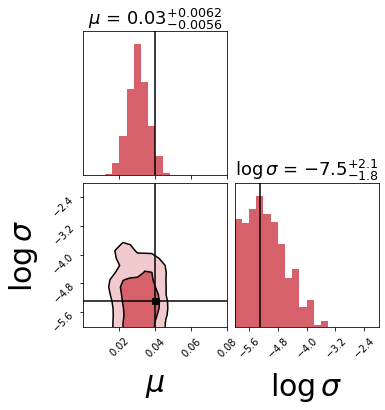

In [10]:
infer_obj.visualize_omega_post(log_idx=None,
                               chain_path=chain_path,
                               corner_kwargs=dict(
                                                 range=[[0, 0.08], [-6, -2]],
                                                 color='#d6616b',
                                                 smooth=0.8,
                                                 alpha=1.0,
                                                 truths=np.array([0.04, np.log(0.005)]),
                                                 label_kwargs={'fontsize': 30},
                                                 labels=[r'$\mu$', r'$\log \sigma$'],
                                                 fill_contours=True,
                                                 plot_datapoints=False,
                                                 plot_contours=True,
                                                 show_titles=True,
                                                 levels=[0.68, 0.95],
                                                 truth_color='k',
                                                 contour_kwargs=dict(linestyles='solid', colors='k'),
                                      #contourf_kwargs=dict(colors='#843c39'),
                                                 quiet=True,
                                                 #quantiles=[0.5 - 0.34, 0.5 + 0.34],
                                                 title_fmt=".2g",
                                                 fig=None,
                                                 title_kwargs={'fontsize': 18},
                                                 #range=[0.99]*len(cols_to_plot),
                                                 use_math_text=True,
                                                 hist_kwargs=dict(density=True, 
                                                                  histtype='stepfilled',))
                                                 ,
                               chain_kwargs=dict(
                                                 flat=True,
                                                 thin=1,
                                                 discard=75
                                                 ))

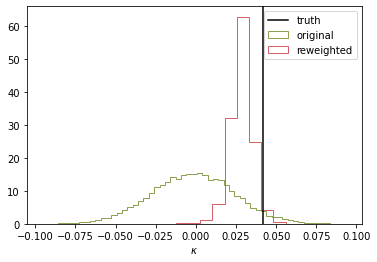

In [11]:
infer_obj.visualize_kappa_post(idx=0, n_samples=50, n_mc_dropout=20,
                               chain_path=chain_path, 
                               interim_pdf_func=norm_obj.pdf,
                               chain_kwargs=dict(
                                                 flat=True,
                                                 thin=1,
                                                 discard=75
                                                 ))

In [12]:
n_test = len(infer_obj.test_dataset) 
k_bnn = infer_obj.get_bnn_kappa()
k_test = test_k.squeeze()  # FIXME
reweighted_stats = dict()
reweighted_stats['minus_sig'] = []
reweighted_stats['med'] = []
reweighted_stats['plus_sig'] = []
reweighted_stats['logp_pre'] = []
reweighted_stats['logp'] = []
reweighted_stats['mad'] = []
reweighted_stats['mae'] = []
for i in range(n_test):
    # Fit KDE on unweighted samples
    kde_pre = stats.gaussian_kde(k_bnn[i, :], bw_method='scott')
    # Fit KDE on weighted samples
    log_weights = infer_obj.get_kappa_log_weights(i, n_samples=50, n_mc_dropout=20,
                                                  chain_path=chain_path, 
                                                  chain_kwargs=dict(flat=True, discard=75),
                                                  interim_pdf_func=norm_obj.pdf)
    kde = stats.gaussian_kde(k_bnn[i, :], weights=np.exp(log_weights))
    # Resample from KDE
    resampled = kde.resample(10000)
    # Compute descriptive stats
    minus_sig, med, plus_sig = np.quantile(resampled, [0.5-0.34, 0.5, 0.5+0.34])
    reweighted_stats['minus_sig'].append(med - minus_sig)
    reweighted_stats['med'].append(med)
    reweighted_stats['plus_sig'].append(plus_sig - med)
    reweighted_stats['logp'].append(kde.logpdf(k_test[i]))
    reweighted_stats['logp_pre'].append(kde_pre.logpdf(k_test[i]))
    reweighted_stats['mad'].append(stats.median_abs_deviation(resampled))
    reweighted_stats['mae'].append(np.median(resampled) - k_test[i])

KeyboardInterrupt: 

Text(0.5, 1.0, 'Pre-reweighting')

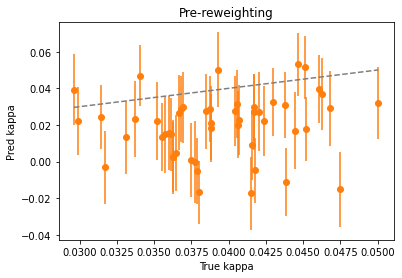

In [17]:
min_p, max_p = np.min(k_test), np.max(k_test)

pre_med = []
pre_mad = []
for i in range(n_test):
    pre_samples = k_bnn[i, 0, :]
    pre_med.append(np.median(pre_samples))
    pre_mad.append(stats.median_abs_deviation(pre_samples))

plt.errorbar(k_test, pre_med, yerr=pre_mad, fmt='o', color='tab:orange')
plt.plot(np.linspace(min_p, max_p, 20), np.linspace(min_p, max_p, 20), 
         color='tab:gray', linestyle='--', label='1-1')
plt.xlabel('True kappa')
plt.ylabel('Pred kappa')
plt.title('Pre-reweighting')

Text(0.5, 1.0, 'Post-reweighting')

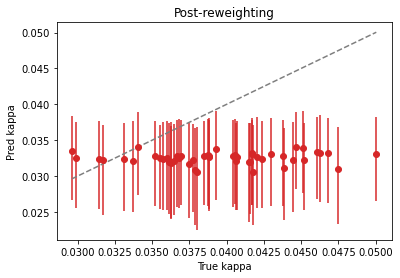

In [16]:
min_p, max_p = np.min(k_test), np.max(k_test)

plt.errorbar(k_test, reweighted_stats['med'],
             yerr=np.stack([reweighted_stats['minus_sig'], reweighted_stats['plus_sig']], axis=0),
             fmt='o', color='tab:red')
plt.plot(np.linspace(min_p, max_p, 20), np.linspace(min_p, max_p, 20), 
         color='tab:gray', linestyle='--', label='1-1')
plt.xlabel('True kappa')
plt.ylabel('Pred kappa')
plt.title('Post-reweighting')

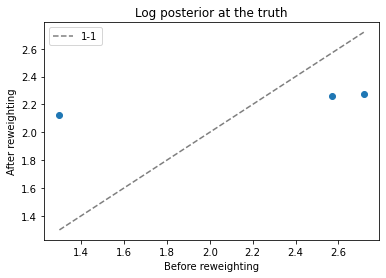

In [13]:
plt.close('all')
min_p, max_p = np.min(reweighted_stats['logp_pre']), np.max(reweighted_stats['logp_pre'])
plt.scatter(reweighted_stats['logp_pre'], reweighted_stats['logp'])
plt.plot(np.linspace(min_p, max_p, 20), np.linspace(min_p, max_p, 20), 
         color='tab:gray', linestyle='--', label='1-1')
plt.title('Log posterior at the truth')
plt.xlabel('Before reweighting')
plt.ylabel('After reweighting')
plt.legend()

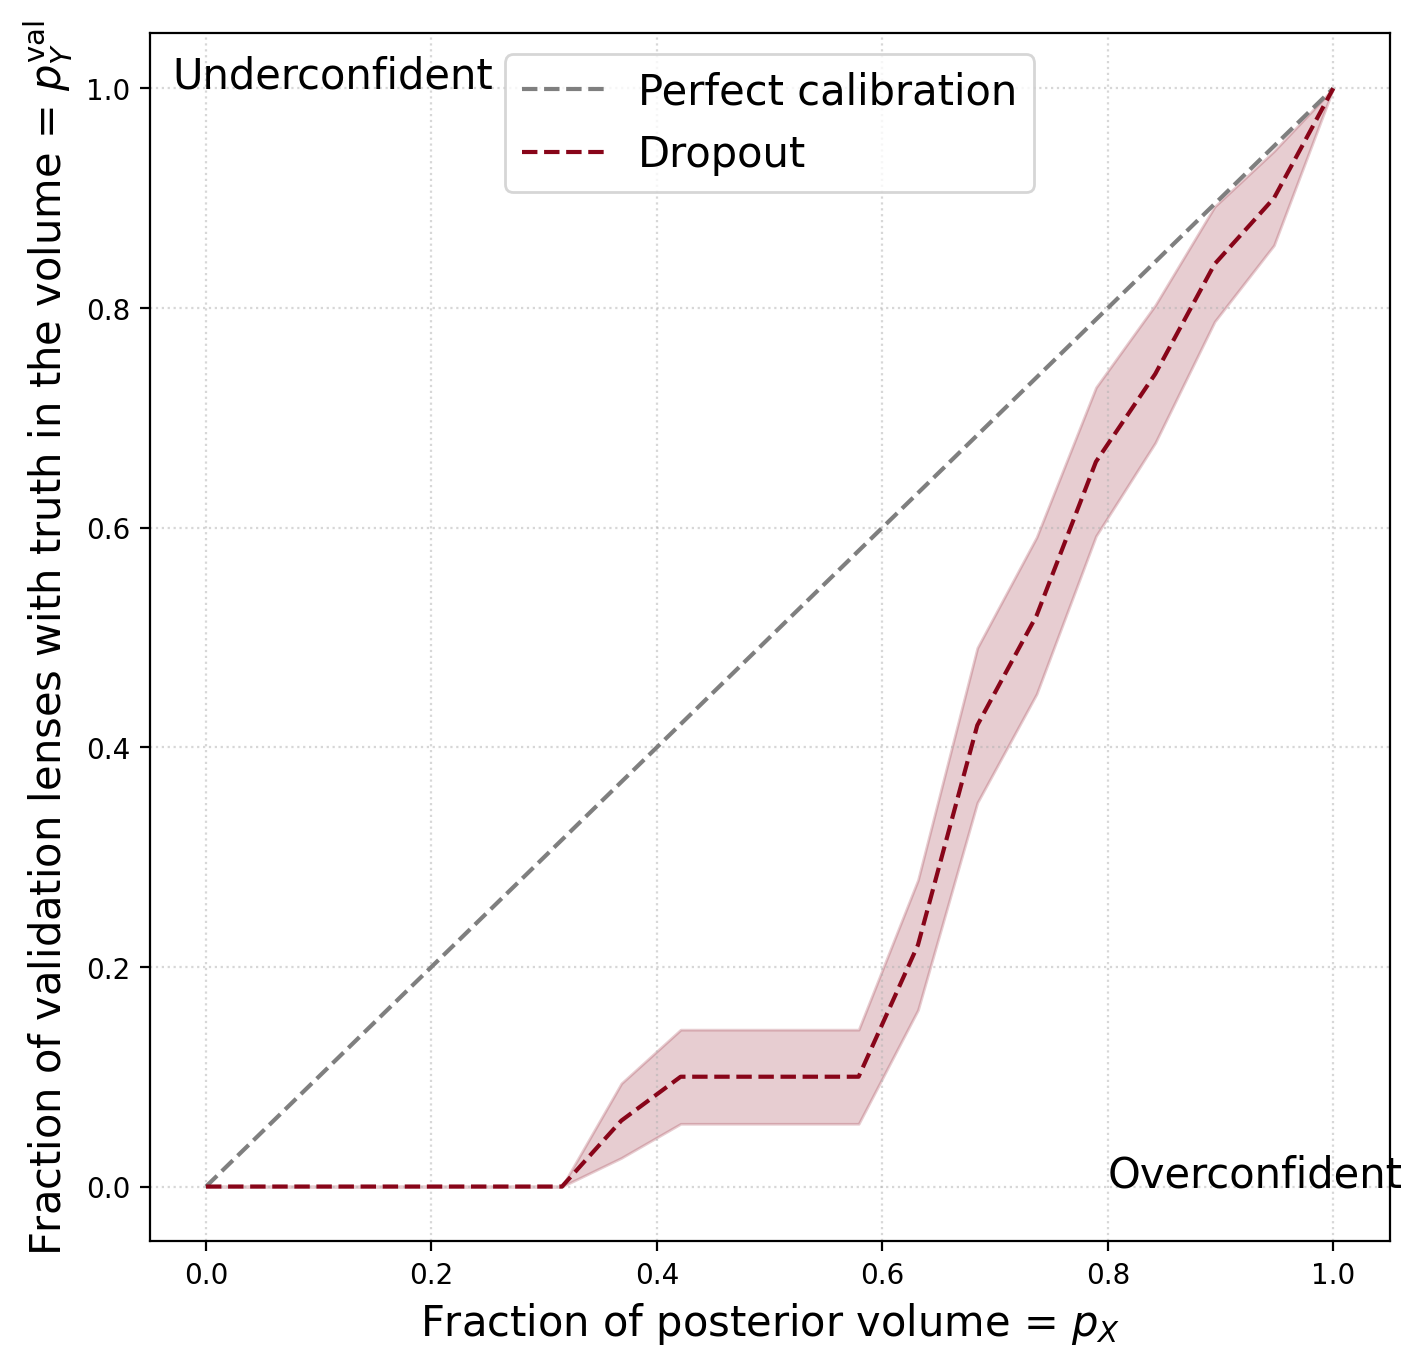

In [13]:
infer_obj.get_calibration_plot()

In [14]:
p = np.load('../p_look.npy')
num = np.load('../num.npy')
denom = np.load('../denom.npy')
xx, yy = np.meshgrid(np.linspace(0, 0.05, 200),
                             np.linspace(-7, -3, 100), indexing='ij')

In [15]:
p.shape, num.shape, denom.shape

((200, 100), (50, 20000), (50, 20000))

Text(0, 0.5, 'log sigma')

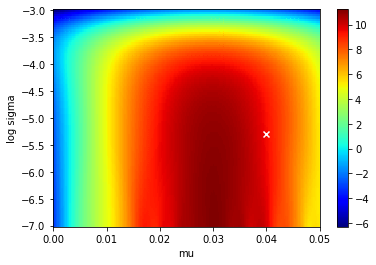

In [16]:
plt.close('all')
plt.pcolor(xx, yy, p, shading='auto', cmap='jet')
plt.colorbar()
plt.scatter(0.04, np.log(0.005), marker='x', color='white')
plt.xlabel('mu')
plt.ylabel('log sigma')

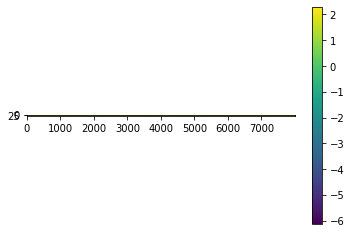

In [28]:
plt.imshow(num)
plt.colorbar()

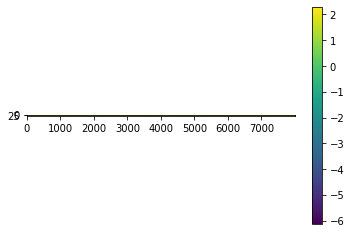

In [29]:
plt.imshow(denom)
plt.colorbar()

In [30]:
np.max(num - denom)

4.440892098500626e-15

In [31]:
k_bnn.shape

(50, 1, 8000)

In [32]:
n = stats.norm(loc=0.01, scale=0.04)
compare = np.log(n.pdf(k_bnn.squeeze(1)))

In [33]:
denom.shape, compare.shape

((50, 8000), (50, 8000))

In [34]:
denom - compare

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
0.5*np.log(2*np.pi)

0.9189385332046727

In [36]:
np.exp(-7)

0.0009118819655545162